In [64]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Conv2D,Dropout,Dense,Flatten,MaxPool2D
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split



In [24]:
rowdata=pd.read_csv('data/fer2013.csv')


In [25]:
rowdata.rename(columns={'emotion':'label','pixels':'feature'},inplace=True)

In [26]:
rowdata.columns

Index(['label', 'feature', 'Usage'], dtype='object')

In [27]:
rowdata.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [28]:
X=rowdata[rowdata.Usage=='Training']
test=rowdata[rowdata.Usage!='Training']


In [29]:
X=X.drop('Usage',axis=1)
test=test.drop('Usage',axis=1)


In [30]:
output_dir='data'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
X.to_csv(os.path.join(output_dir,'train.csv'),index=False)
test.to_csv(os.path.join(output_dir,'test.csv'),index=False)


In [31]:
name = ['angry','disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

In [32]:
train_filename='data/train.csv'
test_filename='test/train.csv'

In [33]:
X=pd.read_csv(train_filename)
test=pd.read_csv(train_filename)

In [34]:
X.columns

Index(['label', 'feature'], dtype='object')

In [35]:
X['label'].value_counts().sort_values()

1     436
5    3171
0    3995
2    4097
4    4830
6    4965
3    7215
Name: label, dtype: int64

In [36]:
class Data_clean():
    def __init__(self,train_df):
        self._train_df=train_df
        self._distribution=train_df['label'].value_counts().sort_values()
        self._train_df['feature'] = self._train_df['feature'].map(lambda x : np.array(list(map(float, x.split()))))
        self._image_size=self._train_df['feature'][0].size
        self._image_shape=(int(np.sqrt(self._image_size)),int(np.sqrt(self._image_size)))
        self._dataNum=self._train_df.shape[0]
        
        self._feature = np.array(self._train_df.feature.map(lambda x: x.reshape(self._image_shape)).values.tolist())
        self._label=self._train_df['label'].values
        self._labelNum=self._train_df['label'].nunique()
        self._onehot=pd.get_dummies(self._train_df['label']).values
    @property
    def distribution(self):
        return self._distribution
    
    @property
    def image_size(self):
        return self._image_size
    
    @property
    def image_shape(self):
        return self._image_shape
    
    @property
    def dataNum(self):
        return self._dataNum
    
    @property
    def feature(self):
        return self._feature
    
    @property
    def label(self):
        return self._label
 
    @property
    def labelNum(self):
        return self._labelNum
    
    @property
    def onehot(self):
        return self._onehot

def plot_images(images,cls_true,cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.创建子图
    fig, axes = plt.subplots(3, 3)#axes子图轴域
    fig.subplots_adjust(hspace=0.3, wspace=0.3)#调整边距和子图的间距
    for i, ax in enumerate(axes.flat):#flat方法是将整个numpy对象转换成了1维对象
        # Get the i'th image and reshape the array.
        #image = images[i].reshape(img_shape)
        
        
        # Ensure the noisy pixel-values are between 0 and 1.
        #image = np.clip(image, 0.0, 1.0)
 
        # Plot image.
        ax.imshow(images[i],
                  cmap = 'gray',#颜色图谱（colormap), 默认绘制为RGB(A)颜色空间。
                  interpolation='nearest')#最近邻差值
        # Show true and predicted classes.

        if cls_pred is None:#还没有预测结果
            xlabel = "True: {0}".format(name[cls_true[i]])#字符串格式化
        else:
            xlabel = "True: {0}, Pred: {1}".format(name[cls_true[i]], name[cls_pred[i]])
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)#把xlabel在图中标注出来
        
        # Remove ticks from the plot.
        ax.set_xticks([])#设置坐标轴刻度
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()


In [37]:
data=Data_clean(X)


In [40]:
label=X['label']

In [41]:
sample_images=[list(label[label==x].index)[0:9] for x in range(data.labelNum)]

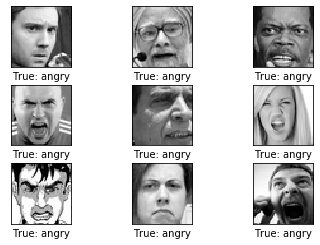

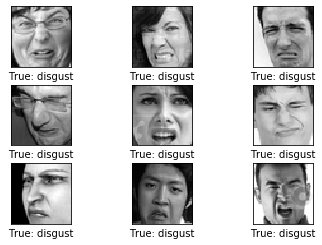

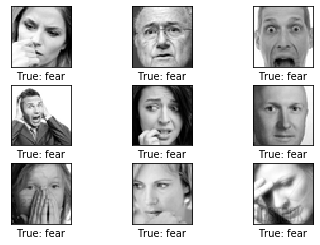

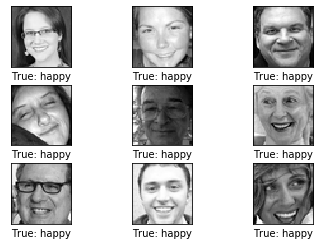

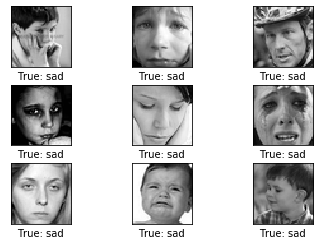

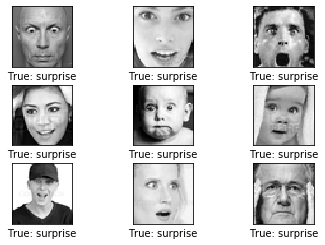

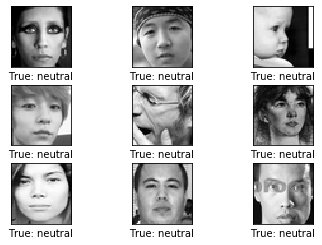

In [42]:
for i in sample_images:
    plot_images(data.feature[i],data.label[i])

In [43]:
X_train=data.feature/255
y_label=data.label
y_onehot=data.onehot

In [44]:
X_train=X_train.reshape([-1,48,48,1])

In [54]:
#split train set and valid set
random_seed=1
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_onehot, test_size = 0.1, random_state=random_seed)

In [86]:
model1=Sequential()
model1.add(Conv2D(64,kernel_size=3,activation='relu',input_shape=[48,48,1],))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Dropout(0.3))
model1.add(Conv2D(128,kernel_size=3,activation='relu'))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Dropout(0.3))

model1.add(Conv2D(256,kernel_size=3,activation='relu'))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Dropout(0.4))

model1.add(Conv2D(512,kernel_size=3,activation='relu'))
model1.add(BatchNormalization(axis=-1))
model1.add(MaxPool2D(pool_size=2,strides=2))
model1.add(Dropout(0.4))

model1.add(Flatten())
model1.add(Dense(1024,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(512,activation='relu'))
model1.add(Dropout(0.5))

model1.add(Dense(7,activation='softmax'))

In [87]:
model1.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization_46 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_42 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 21, 21, 128)       73856     
_________________________________________________________________
batch_normalization_47 (Batc (None, 21, 21, 128)       512       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 10, 10, 128)     

In [77]:
model1.compile(loss='categorical_crossentropy',
               optimizer='adam',
               metrics=['accuracy'])

In [83]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=5,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = False, # Randomly zoom image 
        width_shift_range=False,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=False,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)



In [84]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [82]:

#without data augmentation
#history=model1.fit(X_train,y_onehot,batch_size=128,epochs=10,validation_split=0.2)
batch_size=128
epochs=10
# Fit the model
history = model1.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
 25/201 [==>...........................] - ETA: 2:38 - loss: 2.5300 - accuracy: 0.2034

KeyboardInterrupt: 